# Exploring Order Dependency in LLMs

While LLMs have demonstrated remarkable capabilities in understanding and generating text, they also exhibit a number of unexpected behavioral patterns. Hallucinations are one well known example, but there are others that are less obvious and more subtle.

In this experiment, we'll explore the *order dependency problem*: a language models' sensitivity to the order of tokens in a sequence. Multiple researchers have shown that small changes to the order that information is presented to a model can make a large difference in the model's response. Like hallucinations, order dependency is a significant obstacle to user acceptance and broader adoption of AI solutions. This is because order dependency leads to inconsistent model outputs, making models seem unreliable and eroding users' trust. Understandably so. For AI solutions to deliver on their promises, they need to be more robust. We can't accept healthcare models that change a diagnosis based on the order a patient's labs are entered. Or financial models that approve or deny loan applications based on who is first or last in line.

One specific area where order dependency has been thoroughly studied is in answering multiple choice questions (MCQs). MCQs are widely used as benchmarks to evaluate LLMs' language understanding and reasoning capabilities. However, multiple researchers have independently shown that simply changing the order the choices are presented can dramatically change a model's score. They've also demonstrated this behavior isn't limited to one or two models, but is a general pattern exhibited the decoder-only Transformer architectures that dominate the current landscape.

We'll spend the rest of this experiment exploring the order dependency problem from multiple viewpoints. First, we'll demonstrate the problem on a tiny sample of MCQs. Next, we'll step back and evaluate the extent of the problem. Next, we'll take a closer look at the leading hypotheses for what's causing the sensitivity and then consider several ways to potentially mitigate the issue.

# Parameters

In [1]:
# Sample size
n_questions = 64

# Number of test runs
n_runs = 8

# Setup

In [2]:
#-------------------------------------------------------------------------------
# Imports
#-------------------------------------------------------------------------------

import base64
from collections import Counter
import logging
from io import BytesIO
import os
from pathlib import Path
import random
import re
from time import perf_counter_ns as timer

from IPython.display import display, HTML, Markdown
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llama_benchmarks as llb
from llama_benchmarks.models import llama
from llama_benchmarks.mmlu import Question, Questions, Answer, Answers, MMLULlamaGenerator, OPTIONS

In [3]:
#-------------------------------------------------------------------------------
# Configure Experiment
#-------------------------------------------------------------------------------

# Switch to project root
if os.path.basename(os.getcwd()) == "experiments":
    os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Path to datasets
datasets_path = Path(".build") / "datasets"

In [4]:
%%html
<style>
table.questions td, table.questions th {
    text-align: left !important;
}
</style>

In [5]:
#-------------------------------------------------------------------------------
# Utility Functions
#-------------------------------------------------------------------------------

def show_questions(questions: Questions):
    """Render questions as a table."""

    max_rows = 5
    rows = ""
    for i in range(min(len(questions), max_rows)):
        q = questions[i]
        rows += f"<tr><td>{q.qid}</td><td>{q.category}</td><td>{q.question}</td><td>{q.A}</td><td>{q.B}</td><td>{q.C}</td><td>{q.D}</td><td>{q.answer}</td></tr>"
    
    display(HTML(        
        f"""
        <table class="questions">
        <tr><th>QID</th><th>Category</th><th>Question</th><th>A</th><th>B</th><th>C</th><th>D</th><th>Answer</th></tr>
        {rows}
        </table>
        """
    ))    


def remove_referentials(questions: Questions) -> Questions:
    """Discard questions with options that refer to other options, e.g. A or B."""
    word_pattern = re.compile(r"\b\w+\b")

    results = []
    for q in questions:
        # Look for options that refer to other options, e.g. A, B, A or B
        referential_options = []
        for option in OPTIONS:
            option_value = getattr(q, option)
            
            # Break option_value into words
            words = re.findall(word_pattern, option_value)
    
            # Look for references to options A, B, C, D
            if any(o in words for o in OPTIONS):
                referential_options.append(option)
                continue

            # Look for "of the above" as in None of the above, All of the above, etc
            if "of the above" in option_value:
                referential_options.append(option)
                continue

        # If q does not have self-referential options, keep it
        if not referential_options:
            results.append(q)

    print(f"Discarded {len(questions) - len(results)} questions")

    return tuple(results)


def render_scores(answer: Answer):
    """Render scores for each option as a bar chart."""
    # Plot scores
    fig, ax = plt.subplots()

    default_color = "#1f77b4"
    correct_color = "#2ca02c"
    incorrect_color = "#d62728"
    answer_color = correct_color if answer.correct else incorrect_color
    
    colors = [answer_color if k == answer.actual else default_color for k in answer.scores]
    plt.bar(OPTIONS, [answer.scores[k] for k in OPTIONS], color=colors)

    # Save to png
    buffer = BytesIO()
    fig.savefig(buffer, format="png", bbox_inches="tight")
    plt.close(fig)
    buffer.seek(0)

    # Package png as html snippet
    content = base64.b64encode(buffer.read()).decode("utf-8")
    html = f"<img src=\"data:image/png;base64,{content}\">"
    
    return html
    
    
def example_question_report(qid: int):
    """Display summary report of question."""
    # Select question
    question = next(q for q in questions if q.qid == qid)

    # A
    q = llb.mmlu.swap_answers([question], "A")[0]
    p = llb.mmlu.generate_prompt(examples, q, n_shots=0, header=False)
    a = next(generator(examples, [q]))
    content_a = (p + f"<b>{a.actual}</b>").replace("\n", "<br>")
    scores_a = render_scores(a)
    
    # B
    q = llb.mmlu.swap_answers([question], "B")[0]
    p = llb.mmlu.generate_prompt(examples, q, n_shots=0, header=False)
    a = next(generator(examples, [q]))
    answer_b = a
    content_b = (p + f"<b>{a.actual}</b>").replace("\n", "<br>")
    scores_b = render_scores(a)

    # C
    q = llb.mmlu.swap_answers([question], "C")[0]
    p = llb.mmlu.generate_prompt(examples, q, n_shots=0, header=False)
    a = next(generator(examples, [q]))
    answer_c = a
    content_c = (p + f"<b>{a.actual}</b>").replace("\n", "<br>")
    scores_c = render_scores(a)

    # D
    q = llb.mmlu.swap_answers([question], "D")[0]
    p = llb.mmlu.generate_prompt(examples, q, n_shots=0, header=False)
    a = next(generator(examples, [q]))
    answer_d = a
    content_d = (p + f"<b>{a.actual}</b>").replace("\n", "<br>")
    scores_d = render_scores(a)

    display(HTML(        
        f"""
        <table class="questions">
        <tr><th>A</th><th>B</th><th>C</th><th>D</th></tr>
        <tr><td>{content_a}</td><td>{content_b}</td><td>{content_c}</td><td>{content_d}</td></tr>
        <tr><td>{scores_a}</td><td>{scores_b}</td><td>{scores_c}</td><td>{scores_d}</td></tr>
        </table>
        """
    ))

# Related Work

The ideas and concepts presented here lean heavily on three research papers published over the past 2 years. Pezeshkpour and Hruschka (2023) studied order dependency in GPT4 (OpenAI et al. 2024) and InstructGPT (Ouyang et al. 2022) and hypothesized the issue was caused by a mixture of uncertainty and *positional bias*. Zheng et al. (2024) studied order dependency in 20 LLMs from 4 popular families and suggested the issue was actually due to *token bias* instead of positional bias. Finally, McIlroy-Young et al. (2024) built on the ideas from the first two papers and recommended a general Set-Based Prompting solution.

# MMLU Dataset

First off, we need a source of MCQs. We'll use the standard benchmark Massive Multitask Language Understanding (MMLU) (Hendrycks et al. 2021) dataset. MMLU contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments. MMLU can be downloaded from https://github.com/hendrycks/test.

In [6]:
# Path to downloaded dataset
mmlu_dataset_path = datasets_path / "mmlu"

# Load all questions from MMLU
examples, questions = llb.mmlu.load_dataset(mmlu_dataset_path)
show_questions(questions[0:3])

QID,Category,Question,A,B,C,D,Answer
0,abstract algebra,"Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.",0,4,2,6,B
1,abstract algebra,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the index of in S_5.",8,2,24,120,C
2,abstract algebra,Find all zeros in the indicated finite field of the given polynomial with coefficients in that field. x^5 + 3x^3 + x^2 + 2x in Z_5,0,1,"0,1","0,4",D


In [7]:
print(f"Loaded {len(questions)} questions in {len({q.category for q in questions})} categories.")

Loaded 14042 questions in 57 categories.


## Data Cleaning

### Referential Options

Before we move on to the LLMs, we need to clean up the MMLU data a bit. The first issue we'll tackle are questions with options that refer to other options. For example, consider question 253:

In [8]:
print(llb.mmlu.generate_prompt(examples, next(q for q in questions if q.qid == 253), n_shots=0, header=False))

Question: Which of the following is/are common feature(s) of all fresh (i.e. not eroded) impact craters formed on solid surfaces:

A) ejecta
B) raised rims
C) central peaks
D) A and B only

Answer: 


Note that option D refers to options A and B. As soon as we start moving options around, option D becomes nonsensical. To avoid this situation, we discard any question with options that refer to other options.

In [9]:
examples = remove_referentials(examples)
questions = remove_referentials(questions)

Discarded 21 questions
Discarded 1079 questions


In [10]:
# Discard categories that have less than 4 examples
counts = Counter(q.category for q in examples)
selected_categories = tuple(k for k, v in counts.items() if v < 4)
print(f"Discarding {selected_categories}")

examples = tuple(e for e in examples if e.category not in selected_categories)
questions = tuple(q for q in questions if q.category not in selected_categories)

print(f"Kept {len(questions)} questions from {len({q.category for q in questions})} categories.")

Discarding ('high school computer science',)
Kept 12876 questions from 56 categories.


In [11]:
# Sanity checks

# qids should be unique
assert len({q.qid for q in questions}) == len(questions)

### Answer Distribution

The next issue we'll tackle is bias caused by non-uniform answer distribution. Our goal is to highlight the selection bias inherent to the model. This means we can't give the model any reason to favor one option over another. However, the answers in MMLU are not evenly distributed. To control for this, we'll evenly distribute the answers across the 4 options A, B, C, D in both the example and test questions.

Note that we debias all of the examples here but we debias the questions after random sampling.

In [12]:
# Sample a category
category = examples[0].category

# Record initial answer distribution for category
selected_examples = tuple(e for e in examples if e.category == category)
example_distribution1 = llb.mmlu.answer_distribution(selected_examples)

# Debias examples
examples = llb.mmlu.debias_example_answers(examples)

# Record debiased answer distribution for category
selected = tuple(e for e in examples if e.category == category)
example_distribution2 = llb.mmlu.answer_distribution(selected)

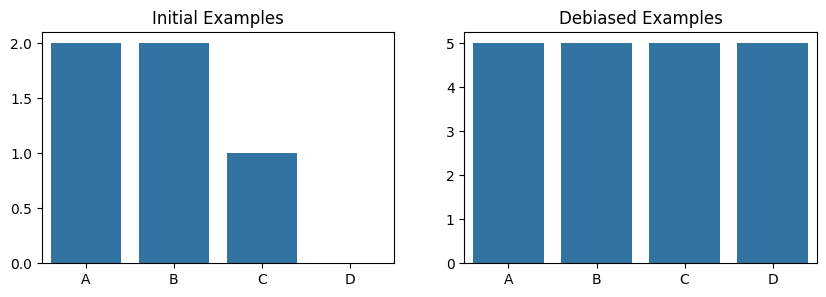

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

sns.barplot(example_distribution1, ax=axs[0])
axs[0].set_title("Initial Examples")

sns.barplot(example_distribution2, ax=axs[1])
axs[1].set_title("Debiased Examples")

fig.subplots_adjust(hspace=0.3)

# Llama Models

We'll focus our experiment on the Llama 3.2 3B LLM. Llama 3.2 3B is a state-of-the-art LLM from Meta that is ideal for local experiments because it's open source and fits on smaller systems with a single GPU. For more details, check out [the Llama 3.2 model card on GitHub](https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/MODEL_CARD.md).

To quantify the model's accuracy, we'll follow the same MCQ evaluation protocol used by Zheng et al. (2024) and others. We combine each question and relevant examples into few-shot prompts and present them to the LLM. Instead of trying to parse the answer from the model's output stream, we extract the logits for tokens "A", "B", "C", "D" from the model's output layer and convert them to probabilities. We're effectively limiting the model's output vocabulary to the 4 options. Not only does this let us quickly identify the model's "answer", it also gives us a direct representation of the model's uncertainty.

In [14]:
# Show prompt example
print(llb.mmlu.generate_prompt(examples, questions[0], n_shots=1))

The following are multiple choice questions (with answers) about abstract algebra.

Question: Find all c in Z_3 such that Z_3[x]/(x^2 + c) is a field.

A) 1
B) 0
C) 2
D) 3

Answer: A

Question: Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.

A) 0
B) 4
C) 2
D) 6

Answer: 


To make the analysis easier, we use a custom generator `llama_benchmarks.mmlu.MMLULlamaGenerator` that provides an custom interface for answering MMLU questions, uses a custom head stage to extracts logits for "A", "B", "C", "D", and avoids all token sampling. This streamlined generator scaffolding is wrapped around the off-the-shelf Llama 3.2 3B model downloaded from Meta (https://www.llama.com/).

In [15]:
config = llama.config("Llama3.2-3B")
config._asdict()

{'device': device(type='mps'),
 'checkpoint_path': PosixPath('/Users/andrewyoung/.llama/checkpoints/Llama3.2-3B'),
 'vocab_size': 128256,
 'd_model': 3072,
 'd_head': 128,
 'd_ffn': 8192,
 'n_layers': 28,
 'n_heads': 24,
 'n_kv_heads': 8,
 'rms_norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'max_seq_len': 8192,
 'temperature': 0.6,
 'top_k': 50,
 'top_p': 0.9,
 'max_completion_tokens': 64}

In [16]:
generator = MMLULlamaGenerator(config)

# Examples of Order Dependency

Let's take a look at a few hand curated examples. For each example, we'll show what happens as we shift the correct answer from A to D.

## Question: What country was once ruled by shoguns?

This is an easy one to start. Not only does the model get it right every time, but you can see a huge difference in the model's confidence levels.

A,B,C,D
Question: What country was once ruled by shoguns?A) JapanB) ChinaC) North KoreaD) TaiwanAnswer: A,Question: What country was once ruled by shoguns?A) ChinaB) JapanC) North KoreaD) TaiwanAnswer: B,Question: What country was once ruled by shoguns?A) ChinaB) North KoreaC) JapanD) TaiwanAnswer: C,Question: What country was once ruled by shoguns?A) ChinaB) TaiwanC) North KoreaD) JapanAnswer: D
,,,

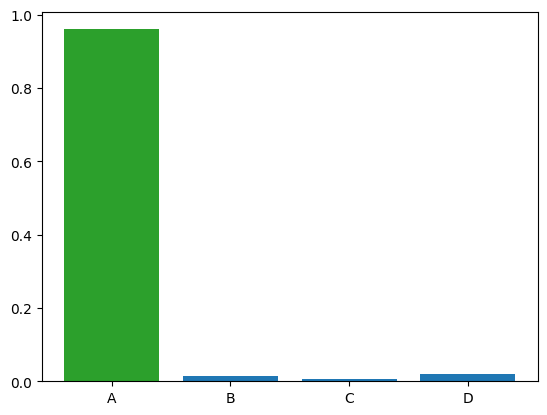
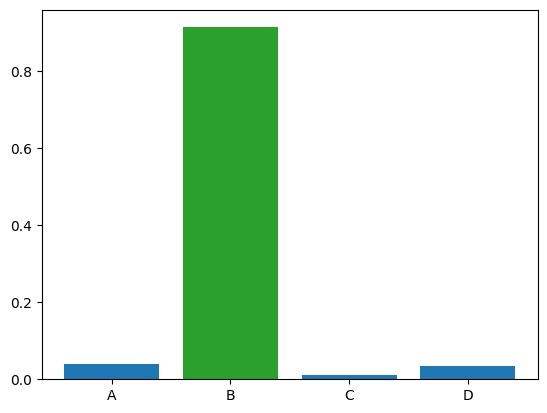
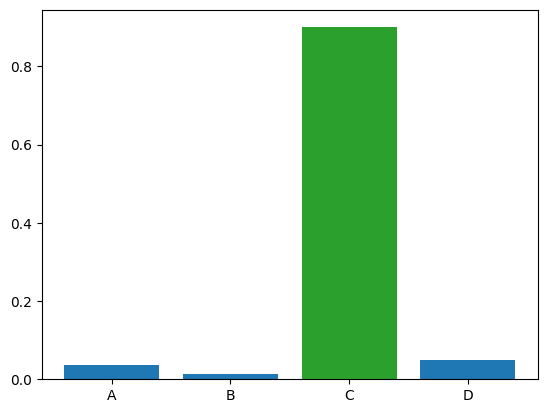
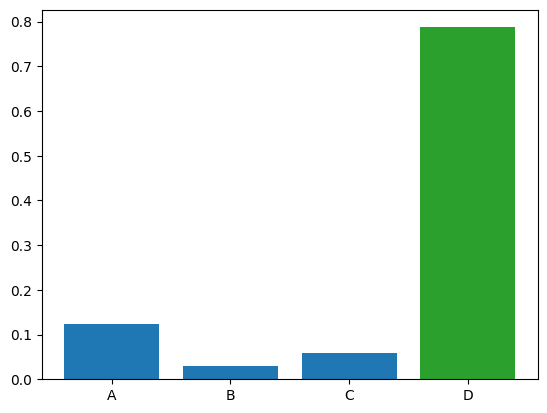

In [17]:
example_question_report(7779)

## Question: What was Richard Nixon's middle name?

A,B,C,D
Question: What was Richard Nixon's middle name?A) MilhousB) MichaelC) MortimerD) MatthewAnswer: A,Question: What was Richard Nixon's middle name?A) MichaelB) MilhousC) MortimerD) MatthewAnswer: B,Question: What was Richard Nixon's middle name?A) MichaelB) MortimerC) MilhousD) MatthewAnswer: B,Question: What was Richard Nixon's middle name?A) MichaelB) MatthewC) MortimerD) MilhousAnswer: D
,,,

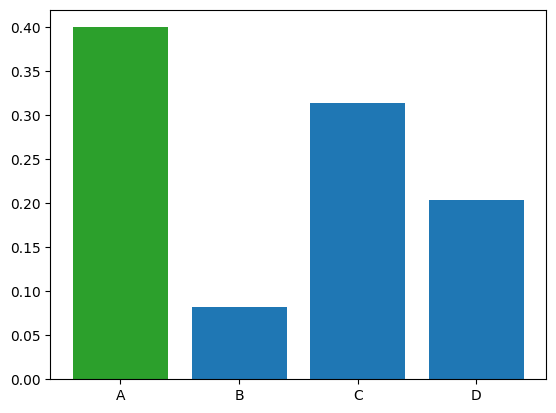
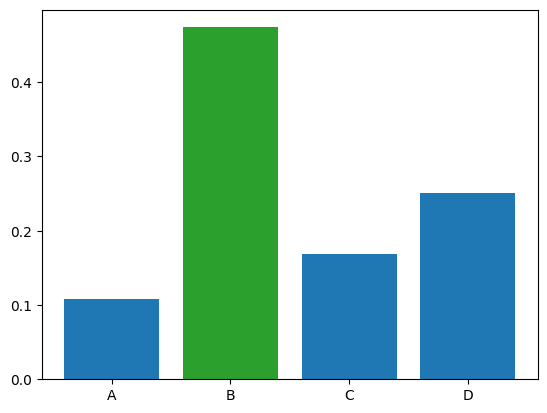
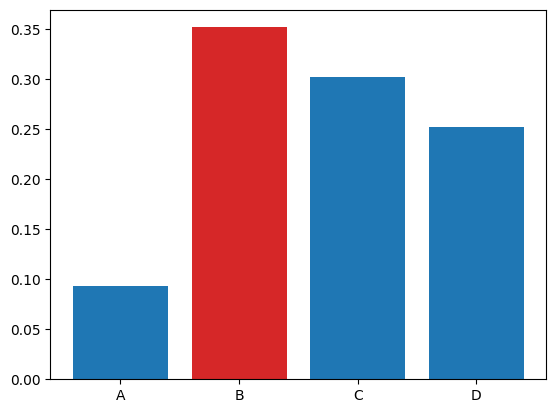
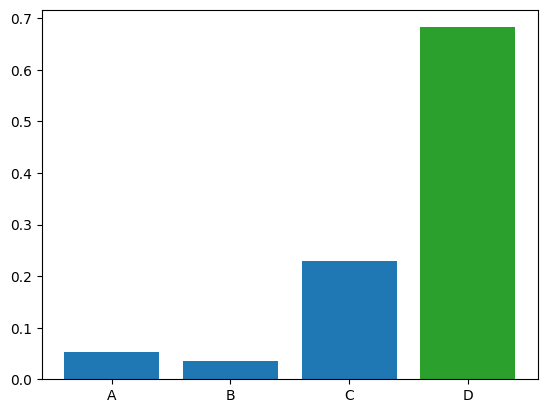

In [18]:
example_question_report(7469)

## Question: In which of the following cases did the Supreme Court decision establish the "separate but equal" doctrine of state-sponsored racial segregation?

If you know the answer, there is nothing tricky about this one. What's interesting here is the model gets it right for the first three scenarios. Not only does it get it right, but it's really confident about the answer. But in the last scenario, the model suddenly decides that "Brown v. Board of Education" is the clear winner even though it barely noticed "Brown v. Board of Education" in the other scenarios. Why?

A,B,C,D
"Question: In which of the following cases did the Supreme Court decision establish the ""separate but equal"" doctrine of state-sponsored racial segregation?A) Plessy v. FergusonB) McCulloch v. MarylandC) Gibbons v. OgdenD) Brown v. Board of EducationAnswer: A","Question: In which of the following cases did the Supreme Court decision establish the ""separate but equal"" doctrine of state-sponsored racial segregation?A) McCulloch v. MarylandB) Plessy v. FergusonC) Gibbons v. OgdenD) Brown v. Board of EducationAnswer: B","Question: In which of the following cases did the Supreme Court decision establish the ""separate but equal"" doctrine of state-sponsored racial segregation?A) Gibbons v. OgdenB) McCulloch v. MarylandC) Plessy v. FergusonD) Brown v. Board of EducationAnswer: C","Question: In which of the following cases did the Supreme Court decision establish the ""separate but equal"" doctrine of state-sponsored racial segregation?A) Brown v. Board of EducationB) McCulloch v. MarylandC) Gibbons v. OgdenD) Plessy v. FergusonAnswer: D"
,,,

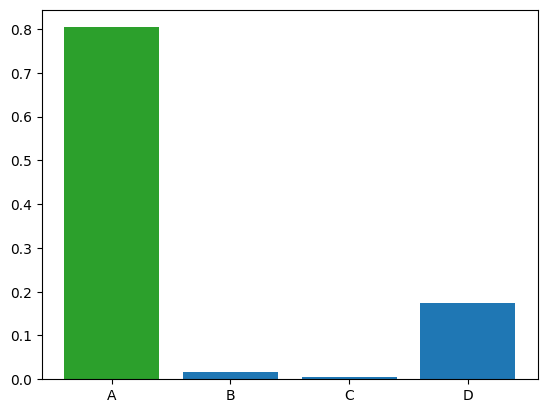
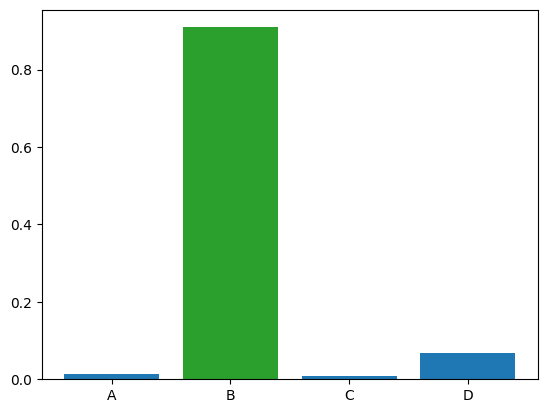
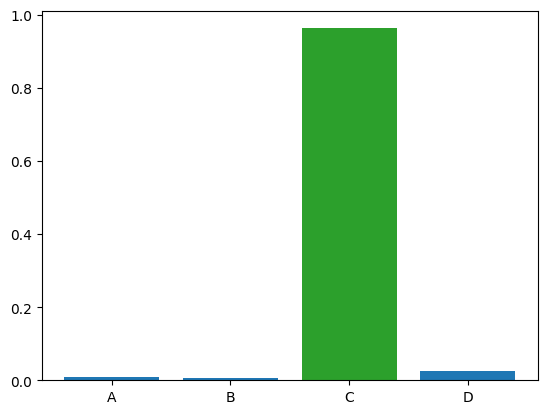
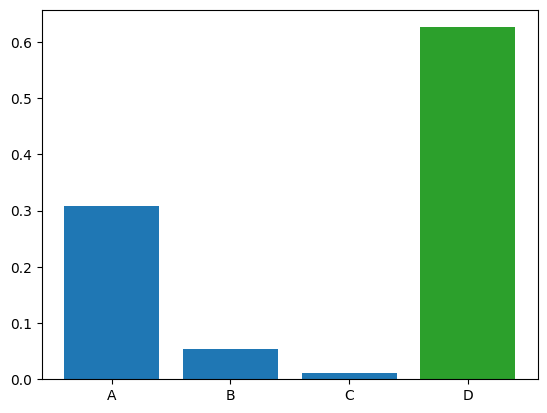

In [19]:
example_question_report(3788)

# Quantifying Order Dependency

Now that we've seen a handful of specific examples, let's step back and try to quantify the extent of the the order dependency problem. We'll follow the same approach used by Zheng et al. (2024) where we record the model's accuracy across 5 segments: U, A, B, C, D. The U segment is the initial "uniform" segment where the answers are evenly distributed across all 4 options. The A, B, C, and D segments represent scenarios where the correct answers are all shifted to one option.

The idea is that if we move the correct answers to option A and the model's accuracy improves relative to the uniform scenario, then this suggests the model favors option A. Conversely, if we move the correct answers to option B and the model's accuracy gets worse, then this suggests the model is avoiding option B. By repeating this process over multiple random samples of questions, we can test the consistency of the model's behavior.

## Zero Shot

We'll start using zero-shot setting where we don't include any examples. This is only made possible because we're limiting the output vocab to A, B, C, D. In a less artificial setting, it would be much harder to reasonable answers without the examples. Another benefit we've discovered is zero-shot experiments are so much faster!

In [20]:
# Zero shot
n_shots = 0

In [21]:
%%time

# Sanity checks

# n_questions must be multiple of 4
assert n_questions % 4 == 0

# Summary
print(f"Running {n_shots}-shot experiment: {n_runs} runs w/ {n_questions}-question samples taken from population of {len(questions)} questions.")

# Reset results
raw_results = []

# Repeat over multiple runs
for run in range(n_runs):

    # Reset results
    metrics = {}
    
    # Randomly select question sample
    selected_questions = random.sample(questions, n_questions)
    
    # Debias questions
    selected_questions = llb.mmlu.debias_question_answers(selected_questions)

    # Verify selected questions are uniformly distributed
    distribution = llb.mmlu.answer_distribution(selected_questions)
    assert len(set(distribution.values())) == 1

    # Iterate through each segment
    for segment in ["U", "A", "B", "C", "D"]:
        segment_questions = selected_questions
    
        # If segment is A, B, C, D swap the answers to the target option
        if segment in OPTIONS:
            segment_questions = llb.mmlu.swap_answers(segment_questions, segment)
    
        # Answer each question
        start_time = timer()
        answers = tuple(a for a in tqdm(generator(examples, segment_questions, n_shots=n_shots), total=n_questions, desc=segment))
        duration = timer() - start_time
        
        # Record performance metrics
        correct = sum(1 for a in answers if a.correct)
        accuracy = correct / n_questions
        rps = 1000000000 * n_questions / duration
        
        metrics[segment] = {
            "questions": segment_questions,
            "answers": answers,
            "n": n_questions,
            "correct": correct,
            "accuracy": accuracy,
            "rps": rps,
        }
    
    raw_results.append(metrics)
    print(f"Completed run {run}")

Running 0-shot experiment: 8 runs w/ 64-question samples taken from population of 12876 questions.


D: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:12<00:00,  5.02it/s]

CPU times: user 3min 34s, sys: 39.6 s, total: 4min 14s
Wall time: 8min 57s


## Analysis

In [22]:
# Post-process raw results
rows = []
for run in raw_results:
    baseline = run["U"]["accuracy"]
    for segment in ["U", "A", "B", "C", "D"]:
        rows.append({
            "segment": segment,
            "accuracy": run[segment]["accuracy"],
            "accuracy_delta": run[segment]["accuracy"] - baseline,
        })
results = DataFrame(rows)

Text(0.5, 1.0, 'Accuracy Delta (runs=8, n=64)')

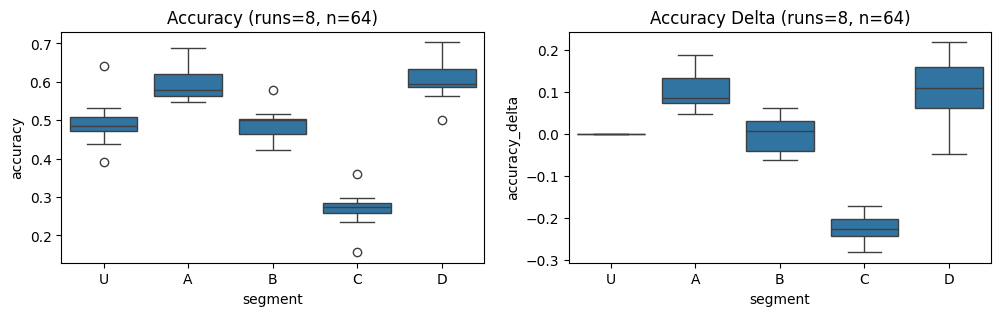

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

# Accuracy
sns.boxplot(x="segment", y="accuracy", data=results, ax=axs[0])
axs[0].set_title(f"Accuracy (runs={n_runs}, n={n_questions})")

# Accuracy Delta
sns.boxplot(x="segment", y="accuracy_delta", data=results, ax=axs[1])
axs[1].set_title(f"Accuracy Delta (runs={n_runs}, n={n_questions})")

# XXX

Next, we'll run the questions by a Llama 3.2 3B LLM, change the order of the options, answer them with the LLM again, and then see which answers changed. Llama 3.2 3B is a state-of-the-art LLM from Meta that is ideal for local experiments because it's open source and fits on a smaller system with a single GPU.

## Workflow

To quantify the model's accuracy, we'll follow the same MCQ evaluation protocol used by Zheng et al. (2024) and others. We combine each question and relevant examples into a 4-shot prompt and present the prompt to the LLM. Instead of trying to parse the answer from the model's output stream, we extract the logits for tokens "A", "B", "C", "D" from the model's output layer and convert them to probabilities. Not only does this let us quickly identify the model's "answer", it also gives us a direct representation of the model's uncertainty.

To make the analysis easier, we use a custom generator `llama_benchmarks.mmlu.MMLULlamaGenerator` that provides an interface that takes MMLU examples and questions, uses a custom head stage to extracts logits for "A", "B", "C", "D", and avoids all token sampling. This streamlined generator scaffolding is wrapped around the off-the-shelf Llama 3.2 3B model downloaded from Meta (https://www.llama.com/).

Next, we'll record the model's accuracy across 5 segments: U, A, B, C, D. The U segment is the initial "uniform" segment where the answers are evenly distributed across all 4 options. The A, B, C, D segments are when the correct answers are shifted entirely to each option. This approach will provide a set of concrete examples we can inspect in more detail and also sets us up to evaluate the model's sensitivity at scale.

In [ ]:
n_questions = 64
questions = sample(questions, n_questions)

## Zero Shot

In [ ]:
results = {}

for segment in ["U", "A", "B", "C", "D"]:
    selected_questions = questions

    # If segment is A, B, C, D swap the answers to the target option
    if segment in OPTIONS:
        selected_questions = llb.mmlu.swap_answers(selected_questions, segment)

    # Answer each question
    start_time = timer()
    answers = tuple(a for a in tqdm(generator(examples, selected_questions, n_shots=0), total=n_questions, desc=segment))
    duration = timer() - start_time
    
    # Record performance metrics
    correct = sum(1 for a in answers if a.correct)
    accuracy = correct / n_questions
    rps = 1000000000 * n_questions / duration
    
    results[segment] = {
        "questions": selected_questions,
        "answers": answers,
        "n": n_questions,
        "correct": correct,
        "accuracy": accuracy,
        "rps": rps,
    }

In [ ]:
data={k: v["accuracy"] for k, v in results.items()}
ax = sns.scatterplot(data)
ax.set_title(f"Single Run (n={n_questions})")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Segment")

Since the sample is random, the details of the accuracy plot will change with every run but you should see a significant difference in accuracy across the segments.

Note that the model's behavior is completely deterministic here. There is no token sampling happening in the generator. If you rerun the same questions through the model, you'll get the same outputs.

## Error Analysis

Let's take a look at a few questions in detail starting with questions that went from correct to incorrect. These are questions where the model gave you the right answer to begin with, sounded like it knew what it was talking about, and then dropped the ball when the question was modified slightly.

In [ ]:
correct_u = {a.qid: a for a in results["U"]["answers"] if a.correct}
incorrect = {
    "A": tuple(a for a in results["A"]["answers"] if a.qid in correct_u and not a.correct),
    "B": tuple(a for a in results["B"]["answers"] if a.qid in correct_u and not a.correct),
    "C": tuple(a for a in results["C"]["answers"] if a.qid in correct_u and not a.correct),
    "D": tuple(a for a in results["D"]["answers"] if a.qid in correct_u and not a.correct),
}

In [ ]:
# candidates = []
# for segment, answers in incorrect.items():
#     for answer in answers:
#         candidates.append((segment, answer))
# candidates = sample(candidates, len(candidates))

In [ ]:
it = iter(candidates)

In [ ]:
candidates = set()
for v in incorrect.values():
    candidates |= {a.qid for a in v}

candidates = tuple(q for q in questions if q.qid in candidates)
it = iter(candidates)

In [ ]:
q = next(it)
print(llb.mmlu.generate_prompt(examples, q, n_shots=0))

In [ ]:
q.qid

In [ ]:
len(candidates)

In [ ]:
segment, incorrect_answer = next(it)
incorrect_question = next(q for q in results[segment]["questions"] if q.qid == incorrect_answer.qid)
correct_answer = correct_u[incorrect_answer.qid]
correct_question = next(q for q in results["U"]["questions"] if q.qid == correct_answer.qid)

print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))

### Incorrect 0

In [ ]:
segment, incorrect_answer = next(it)
incorrect_question = next(q for q in results[segment]["questions"] if q.qid == incorrect_answer.qid)
correct_answer = correct_u[incorrect_answer.qid]
correct_question = next(q for q in results["U"]["questions"] if q.qid == correct_answer.qid)

**Correct Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

**Incorrect Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

### Incorrect 1

In [ ]:
segment, incorrect_answer = next(it)
incorrect_question = next(q for q in results[segment]["questions"] if q.qid == incorrect_answer.qid)
correct_answer = correct_u[incorrect_answer.qid]
correct_question = next(q for q in results["U"]["questions"] if q.qid == correct_answer.qid)

**Correct Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

**Incorrect Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

### Incorrect 2

In [ ]:
segment, incorrect_answer = next(it)
incorrect_question = next(q for q in results[segment]["questions"] if q.qid == incorrect_answer.qid)
correct_answer = correct_u[incorrect_answer.qid]
correct_question = next(q for q in results["U"]["questions"] if q.qid == correct_answer.qid)

**Correct Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

**Incorrect Question**

In [ ]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

## Key Observations

One anecdotal pattern that immediately stands out is the model seems to stick with the original option even after we switched the answers. It's as if the model simply guessed correctly the first time and then stuck with the same guess the second time.

# Exploring Potential Order Dependency Causes

# Mitigating Order Dependency

# References

Almazrouei, Ebtesam, Hamza Alobeidli, Abdulaziz Alshamsi, Alessandro Cappelli, Ruxandra Cojocaru, Mérouane Debbah, Étienne Goffinet, et al. 2023. “The Falcon Series of Open Language Models.” arXiv. https://doi.org/10.48550/arXiv.2311.16867.

Dubey, Abhimanyu, Abhinav Jauhri, Abhinav Pandey, Abhishek Kadian, Ahmad Al-Dahle, Aiesha Letman, Akhil Mathur, et al. 2024. “The Llama 3 Herd of Models.” arXiv.Org. July 31, 2024. https://arxiv.org/abs/2407.21783v2.

Hendrycks, Dan, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. 2021. “Measuring Massive Multitask Language Understanding.” arXiv. https://doi.org/10.48550/arXiv.2009.03300.

Liusie, Adian, Potsawee Manakul, and Mark J. F. Gales. 2024. “LLM Comparative Assessment: Zero-Shot NLG Evaluation through Pairwise Comparisons Using Large Language Models.” arXiv. https://doi.org/10.48550/arXiv.2307.07889.

McIlroy-Young, Reid, Katrina Brown, Conlan Olson, Linjun Zhang, and Cynthia Dwork. 2024. “Set-Based Prompting: Provably Solving the Language Model Order Dependency Problem.” arXiv. https://doi.org/10.48550/arXiv.2406.06581.

OpenAI, Josh Achiam, Steven Adler, Sandhini Agarwal, Lama Ahmad, Ilge Akkaya, Florencia Leoni Aleman, et al. 2024. “GPT-4 Technical Report.” arXiv. https://doi.org/10.48550/arXiv.2303.08774.

Ouyang, Long, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L. Wainwright, Pamela Mishkin, Chong Zhang, et al. 2022. “Training Language Models to Follow Instructions with Human Feedback.” arXiv. https://doi.org/10.48550/arXiv.2203.02155.

Pezeshkpour, Pouya, and Estevam Hruschka. 2023. “Large Language Models Sensitivity to The Order of Options in Multiple-Choice Questions.” arXiv. https://doi.org/10.48550/arXiv.2308.11483.

“Vicuna: An Open-Source Chatbot Impressing GPT-4 with 90%* ChatGPT Quality | LMSYS Org.” n.d. Accessed November 7, 2024. https://lmsys.org/blog/2023-03-30-vicuna.

Zheng, Chujie, Hao Zhou, Fandong Meng, Jie Zhou, and Minlie Huang. 2024. “Large Language Models Are Not Robust Multiple Choice Selectors.” arXiv. https://doi.org/10.48550/arXiv.2309.03882.